Vadim Pryadilshchikov

In [29]:
import matplotlib.pyplot as plt
import glob
import os.path as osp
import cv2
import numpy as np

In [30]:
def keypoints_detection_sift(input_img):
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kps, dscrs = sift.detectAndCompute(gray, None)
    return kps, dscrs

In [31]:
def keypoints_matching_knn(dscrs1, dscrs2, threshold=0.6):
    bf = cv2.BFMatcher(cv2.NORM_L2)
    knn_matches = bf.knnMatch(dscrs1, dscrs2, k=2)
    
    good_matches = []
    for neighbour_1, neighbour_2 in knn_matches:
        if neighbour_1.distance < threshold * neighbour_2.distance:
            good_matches.append(neighbour_1)
    return good_matches

In [32]:
def find_homography(src_keypoints, dst_keypoints, matches, threshold=0.7):
    
    src_pts = np.float32(
        [src_keypoints[m.queryIdx].pt for m in matches]
    ).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [dst_keypoints[m.trainIdx].pt for m in matches]
    ).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(
        src_pts,
        dst_pts,
        cv2.RANSAC,
        ransacReprojThreshold=threshold,
        maxIters=20000,
        confidence=0.995
    )

    return M, mask.ravel().tolist()

In [33]:
def stitch_images(img0, img1, threshold = 0.75, mask=None):
    images_info = []
    for img in (img0, img1):
        keypoints, descriptors = keypoints_detection_sift(img)
        images_info.append(
            {
                'img': img,
                'keypoints': keypoints,
                'descriptors': descriptors,
            }
        )
    
    matches = keypoints_matching_knn(
        images_info[1]['descriptors'],
        images_info[0]['descriptors'],
        threshold,
    )

    if len(matches)<4:
        raise Exception("<4 Matches")
    
    M, matches_mask = find_homography(images_info[1]['keypoints'], images_info[0]['keypoints'], matches,4)

    width = img0.shape[1] + img1.shape[1]
    height = max(img0.shape[0], img1.shape[0])

    if mask is not None:
        result = cv2.warpPerspective(img1, M, (img0.shape[1], img0.shape[0]))
        result = np.where(mask != 0, img0, result)
    else:
        result = cv2.warpPerspective(img1, M, (width, height))
        result[0:img0.shape[0], 0:img0.shape[1]] = img0


    return result

    

In [34]:
# prepare mask for filling empty pixels in panorama after stitching
def prepare_mask(panorama):
    mask = np.where(panorama.sum(axis=2) != 0, 1, 0).astype('uint8')
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = np.dstack([mask, ] * 3)

    return mask


True

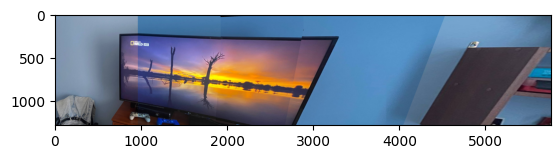

In [35]:
input_dir = 'images'
ipaths = sorted(glob.glob(osp.join(input_dir, 'img*.jpeg')))

panorama = stitch_images(plt.imread(ipaths[0]), plt.imread(ipaths[1]))

# apply stitch with mask to fill zero pixels
panorama = stitch_images(panorama, plt.imread(ipaths[2]), mask=prepare_mask(panorama))
panorama = stitch_images(panorama, plt.imread(ipaths[2]))

panorama = stitch_images(panorama, plt.imread(ipaths[3]), mask=prepare_mask(panorama))
panorama = stitch_images(panorama, plt.imread(ipaths[3]))

# this trick was done because direct stitching of img_4 to panorama was very bad 
panorama_01 = stitch_images(plt.imread(ipaths[3]), plt.imread(ipaths[4]))
panorama = stitch_images(panorama, panorama_01)

plt.imshow(panorama)

result = cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR)
cv2.imwrite(osp.join(input_dir, 'result.jpeg'), result)

